# Week 5 - Support Vector Machines (SVMs), the Kernel Trick, and Regularization for SVMs

 #### <font color='plum'> RESPONSES IN THIS COLOR


For Week 5, include concepts such as support vector machines, the kernel trick, and regularization for support vector machines. 

# Imports

In [27]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt 
import kagglehub 
import time

from sklearn.experimental import enable_halving_search_cv  # Needed to enable
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.base import BaseEstimator

from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    HalvingGridSearchCV,
    RepeatedStratifiedKFold, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold, 
    cross_val_predict, 
    cross_validate, 
    StratifiedKFold, 
    KFold
)

# # explicitly require this experimental feature
# from sklearn.experimental import enable_halving_search_cv # noqa
# # now you can import normally from model_selection
# from sklearn.model_selection import HalvingGridSearchCV

from sklearn.metrics import (
    r2_score, 
    mean_squared_error, 
    root_mean_squared_error,
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score, 
    average_precision_score, 
    make_scorer, 
    classification_report, 
    confusion_matrix, 
    roc_curve, 
    auc,
    precision_recall_curve,
    ConfusionMatrixDisplay
)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_regression
from datetime         import datetime, timedelta
from tqdm             import tqdm
from typing import Any, Dict, List, Union, Tuple
from collections import Counter
from scipy.stats import randint
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder


%matplotlib inline

from kagglehub              import KaggleDatasetAdapter


In [28]:

sns.set_theme(font_scale=0.8) 
# plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams['axes.titlesize']  = 10
plt.rcParams['axes.labelsize']  = 8
plt.rcParams['lines.linewidth'] = 0.5
# plt.rcParams['lines.markersize'] = 3
plt.rcParams['axes.edgecolor']  = 'gray'
plt.rcParams['xtick.color']     = 'gray'
plt.rcParams['ytick.color'] = 'gray'
plt.rcParams['xtick.color'] = 'gray'
plt.rcParams['ytick.color'] = 'gray'
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 8

# Utility Functions

In [29]:
# globals
random_state    = 42
test_size       = 0.2
n_jobs          = -1
font_size       = 8

In [30]:
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

#### null counts

In [31]:
def show_null_counts_features(df: pd.DataFrame) -> pd.DataFrame:
    """
        Identifies and summarizes columns with missing values in given dataframe .

        Steps performed:
            1. Count Null Values: Calculates the total number of null values in each column.
            2. Calculate Null Percentage: Computes the percentage of null values for each column, rounded to two decimal places.
            3. Determine Feature Types: Identifies whether each column is numeric or categorical based on its data type.
            4. Filter and Sort Columns: Filters out columns without missing values and sorts the remaining columns in descending order of their null percentage.
            5. Display Summary: Prints the total number of samples in the dataset. If there are no null values, it informs the user. Otherwise, it prints a table summarizing the columns with missing values, including the feature name, number of null values, null percentage, and feature type.

        Parameters:
            df (pd.DataFrame): The DataFrame to analyze.

        Returns:
            pd.DataFrame: A DataFrame containing the columns with missing values, along with their null counts, null percentages, and feature types.
    """
    # Count the nulls and calculate the %
    count_nulls = df.isnull().sum()
    df_nulls = (df.isnull().mean() * 100).round(2)
    
    # Determine if the column is numeric or non-numeric
    feature_types = df.dtypes.apply(lambda x: 'Numeric' if np.issubdtype(x, np.number) else 'Categorical')
    
    # Filter out the columns with missing values and sort them in descending order
    missing_data = pd.DataFrame({
        'Feature': count_nulls[count_nulls > 0].index,
        '# Null Values': count_nulls[count_nulls > 0].values, 
        'Null %': df_nulls[df_nulls > 0].values,
        'Type': feature_types[count_nulls > 0].values
    }).sort_values(by='Null %', ascending=False)
    
    print(f'The dataset contains {len(df)} samples.\n')

    if (len(missing_data) == 0):
        print("There are no null values in the dataset!")
    else:
        # Print null value stats
        print('Feature Name    # Nulls      Null %    Type')
        print('------------    -------      ------    ----')
        for index, row in missing_data.iterrows():
            print(f"{row['Feature']:<15} {row['# Null Values']:<12} {row['Null %']:,.2f}%   {row['Type']}")

    return missing_data

#### plot_roc_auc_curve

In [32]:
def plot_roc_auc_curve(classifier, X_test, y_test, title='ROC AUC Curve', ax=None):
    """
    Plots the ROC AUC Curve, automatically using decision_function or predict_proba.
    This is robust for SVC models where probability=False (using decision_function)
    or where probability=True (using predict_proba).
    """
    # 1. Determine the appropriate scoring method
    if hasattr(classifier, 'predict_proba'):
        # Use probabilities (e.g., if probability=True or for Logistic Regression)
        y_score = classifier.predict_proba(X_test)[:, 1]
    elif hasattr(classifier, 'decision_function'):
        # Use decision scores (Standard for SVC where probability=False)
        y_score = classifier.decision_function(X_test)
    else:
        raise AttributeError("Classifier lacks both 'predict_proba' and 'decision_function'. Cannot compute ROC curve.")

    # 2. Compute ROC curve and ROC AUC
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    # 3. Plotting logic
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))

    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{title}: AUC = {roc_auc:.2f}')
    ax.legend(loc="lower right")
    return ax



#### plot_precision_recall_curve

In [33]:
def plot_precision_recall_curve(classifier, X_test, y_test, title='Precision-Recall Curve', ax=None):
    """
    Plots the Precision-Recall Curve, automatically using decision_function or predict_proba.
    This is robust for SVC models where probability=False (using decision_function)
    or where probability=True (using predict_proba).
    """
    # 1. Determine the appropriate scoring method
    if hasattr(classifier, 'predict_proba'):
        # Use probabilities
        y_score = classifier.predict_proba(X_test)[:, 1]
    elif hasattr(classifier, 'decision_function'):
        # Use decision scores
        y_score = classifier.decision_function(X_test)
    else:
        raise AttributeError("Classifier lacks both 'predict_proba' and 'decision_function'. Cannot compute P-R curve.")

    # 2. Compute precision-recall pairs and average precision score
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    avg_precision = average_precision_score(y_test, y_score)

    # 3. Plotting logic
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))

    # Plot the precision-recall curve
    ax.plot(recall, precision, color='midnightblue', lw=2, label=f'PR curve (AP = {avg_precision:.2f})')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'{title}: Avg. Precision = {avg_precision:.2f}')
    ax.legend(loc="lower left")
    return ax


#### plot_confusion_matrix

In [34]:
def plot_confusion_matrix(y_true, y_pred, model_name, labels, ax = None):
    """
    Plots a highly readable confusion matrix with TN, FP, FN, TP labels.
    """
    font_size = 10
    plt.rcParams.update({"font.size": font_size})
    cm = confusion_matrix(y_true, y_pred)

    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 3))

    sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", ax=ax,
                xticklabels=labels, yticklabels=labels)

    # Add TP, TN, FP, FN labels
    height, width = cm.shape
    label_matrix = [["TN", "FP"], ["FN", "TP"]]
    for i in range(height):
        for j in range(width):
            ax.text(j + 0.5, i + 0.7, f"\n{label_matrix[i][j]}",
                    ha='center', va='center', color='white', fontsize=8, fontweight='bold')

    # Note: Using ax.set_title directly handles the title formatting better
    ax.set_title(f"Confusion Matrix - {model_name}")
    ax.set_xlabel("Predicted", fontsize=font_size)
    ax.set_ylabel("True", fontsize=font_size)
    plt.tight_layout()
    return ax



#### plot_curves

In [35]:
def plot_curves(classifier, X_test, y_test, model_name, target_labels):
    """
    Plots ROC AUC and Precision-Recall curves side by side for a given classifier.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot ROC AUC Curve
    plot_roc_auc_curve(classifier, X_test, y_test, title=f'ROC AUC - {model_name}', ax=ax1)

    # Plot Precision-Recall Curve
    plot_precision_recall_curve(classifier, X_test, y_test, title=f'Precision-Recall - {model_name}', ax=ax2)

    plt.tight_layout()
    plt.show()
    return fig

#### plot_feature_importance

In [36]:

def plot_feature_importance(search, X, title="Feature Importance", color="midnightblue", ax=None):
    """
    Plots a horizontal bar chart of feature importances from the best estimator in a search object,
    sorted in descending order (most important features at the top).

        Parameters:
            - search: A fitted GridSearchCV or RandomizedSearchCV object with a tree-based estimator.
            - X: pandas DataFrame of features used to train the model.
            - title: str, title of the plot.
            - color: str, color of the bars.
            - ax: matplotlib Axes object, optional. If None, a new figure and axes will be created.
    """
    # Get  best model from the search object
    best_model = search.best_estimator_

    # Check if  model has feature_importances_ attribute
    if not hasattr(best_model, "feature_importances_"):
        raise AttributeError("The best estimator does not have 'feature_importances_' attribute.")

    # Extract and sort feature importances
    importances         = best_model.feature_importances_
    sorted_indices      = np.argsort(importances)[::-1]
    sorted_features     = X.columns[sorted_indices]
    sorted_importances  = importances[sorted_indices]

    # Create plot if no Axes object is provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))

    ax.barh(sorted_features, sorted_importances, color=color)
    ax.invert_yaxis()  # Most important features at the top
    ax.set_xlabel("Importance")
    ax.set_title(title)

    plt.tight_layout()
    plt.show()


#### plot_metrics

In [37]:
def plot_metrics(param, 
                 parameter_list, 
                 cv_accuracies, 
                 train_accuracies, 
                 test_accuracies, 
                 std_cvs, 
                 best_index, 
                 model_name
                 ):
    """Plots the accuracy and standard deviation metrics."""
    plt.rcParams.update({"font.size": font_size})
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (8, 5), sharex=True)
    
    # Use only as many parameter values as computed
    partial_param_list = parameter_list[:len(cv_accuracies)]
    
    # Check if our parameter list is Boolean for proper labeling
    is_boolean      = all(isinstance(val, bool) for val in partial_param_list)
    if is_boolean: 
        # Convert booleans to integer indices for plotting
        x_vals      = list(range(len(partial_param_list)))
        x_labels    = [str(val) for val in partial_param_list]
    else:
        x_vals      = partial_param_list
        x_labels    = partial_param_list
    
    metric = 'Accuracy'

    # ----- First plot: Accuracy ----------------------------------------------------------
    ax1.set_title(f"{model_name} | {metric} vs {param}")
    
    ax1.plot(x_vals, cv_accuracies, marker = '.', label = f"CV {metric}", color = 'midnightblue')
    ax1.plot(x_vals, train_accuracies, marker = '.', label = f"Train {metric}", color = 'green')
    ax1.plot(x_vals, test_accuracies, marker = '.',  label = f"Test {metric}", color = 'orange')
    ax1.scatter([x_vals[best_index]], [cv_accuracies[best_index]], marker='x', s = 100, label = f"Best CV {metric}", color = 'red')
    
    ax1.set_ylabel(metric)
    ax1.legend()
    ax1.grid()
    
    # ----- Second plot: CV Standard Deviation ----------------------------------------------------------
    ax2.set_title(f"{model_name} | CV Standard Deviation vs {param}")
    ax2.plot(x_vals, std_cvs, marker='.', label = f"CV {metric} Std", color = 'midnightblue')
    ax2.set_xlabel(param)
    ax2.set_ylabel("Standard Deviation")
    ax2.legend()
    ax2.grid(alpha = 0.5)
    
    # If using boolean x-values, set custom ticks
    if is_boolean:
        ax2.set_xticks(x_vals)
        ax2.set_xticklabels(x_labels)
    
    plt.tight_layout()
    plt.show()


# 3. Datasets

## <font color='plum'> 3.a. Diabetes Health Indicators Dataset
Over 250,000 responses from a U.S. national health survey with demographic and lifestyle variables (e.g., BMI, activity level, smoking, sleep, general health).

Designed for predicting diabetes status (none, pre-diabetic, diabetic).
https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset

### Load & Clean

In [63]:
file_path = "alexteboul/diabetes-health-indicators-dataset"
file_name = "diabetes_binary_5050split_health_indicators_BRFSS2015.csv"

#diabetes_012_health_indicators_BRFSS2015.csv
#diabetes_binary_health_indicators_BRFSS2015.csv

# Load the latest version
df_3a = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  file_path,
  file_name,
)
df_3a.columns = df_3a.columns.str.strip() 
# df_3a.head(n = 10)

In [65]:

target_col  = 'Diabetes_binary'
X           = df_3a.drop(columns = [target_col])
y           = df_3a[target_col]

# Identify column types based on user's logic (nunique > 2 for numeric)
# SVMs are sensitive to feature scaling, so  identify features that need it.
numeric_cols        = []
categorical_cols    = [] # These are binary (0/1) based on the user's definition

# Use column names from X directly
feature_cols = X.columns.tolist()

for col in feature_cols:
    # The user's criteria for a numeric column to be scaled is having more than 2 unique values.
    # Columns with <= 2 unique values are considered binary/categorical and will be passed through.
    if df_3a[col].nunique() > 2:
        numeric_cols.append(col)
    else:
        categorical_cols.append(col)

dict_outcome = {
    0: 'No Diabetes',
    1: 'Pre-/Diabetes'
}

print("\n--- Feature Classification Summary ---")
print(f"Total Features: {len(feature_cols)}")
print(f"Numeric Features (to be scaled): {numeric_cols}")
print(f"Binary/Categorical Features (to be passed through): {categorical_cols}\n")

# --- 3. Data Splitting: Create the final train/test split (80/20) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = test_size, random_state = random_state, stratify = y
)
print(f"Data Split: Training set size = {X_train.shape[0]}, Test set size = {X_test.shape[0]}")
print(f"Training Target Balance (0/1): {np.bincount(y_train.astype(int))}")
print("--- Data Preparation Complete ---\n")




--- Feature Classification Summary ---
Total Features: 21
Numeric Features (to be scaled): ['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']
Binary/Categorical Features (to be passed through): ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex']

Data Split: Training set size = 56553, Test set size = 14139
Training Target Balance (0/1): [28276 28277]
--- Data Preparation Complete ---



### SVM: Baseline

In [40]:
dataset_3a = 'Diabetes Health Indicators'
#  Manual Feature Scaling (Required for SVM) ---
print("--- Scaling Numeric Features Manually ---")

# Initialize Scaler (fit only on training data)
scaler = StandardScaler()
scaler.fit(X_train[numeric_cols])

# Transform Numeric Columns
X_train_numeric_scaled  = scaler.transform(X_train[numeric_cols])
X_test_numeric_scaled   = scaler.transform(X_test[numeric_cols])

# Convert back to DataFrames
X_train_numeric_scaled_df = pd.DataFrame(X_train_numeric_scaled, columns=numeric_cols, index=X_train.index)
X_test_numeric_scaled_df  = pd.DataFrame(X_test_numeric_scaled, columns=numeric_cols, index=X_test.index)

# Combine scaled numeric features with unscaled categorical/binary features
X_train_final   = pd.concat([X_train_numeric_scaled_df, X_train[categorical_cols]], axis=1)
X_test_final    = pd.concat([X_test_numeric_scaled_df, X_test[categorical_cols]], axis=1)

print(f"Final feature matrix shape after scaling and combining: {X_train_final.shape}")
print("--- Scaling Complete ---\n")


#  Standard SVM Model Training and Evaluation ---
start = time.time()

# Define the SVM Classifier (no pipeline, no probability=True)
svm_model = SVC(kernel='linear', random_state = random_state)

# Train  on  entire SCALED training set
print("Training standard SVM model on full scaled training set...")
svm_model.fit(X_train_final, y_train)

# Predict on hold-out scaled test set
y_pred = svm_model.predict(X_test_final)

end             = time.time()
execution_time  = format_hms(end - start)
time_stamp      = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Execution Time: {execution_time}")

print(f"\n--- Final Model Evaluation ---")
accuracy        = accuracy_score(y_test, y_pred)
print(f"Final Test Accuracy: {accuracy:.4f}\n")

precision       = precision_score(y_test, y_pred)
recall          = recall_score(y_test, y_pred)
f1              = f1_score(y_test, y_pred)
f1_macro        = f1_score(y_test, y_pred, average='macro')
f1_weighted     = f1_score(y_test, y_pred, average='weighted')


conf_matrix = confusion_matrix(y_test, y_pred)
cm_df       = pd.DataFrame(conf_matrix, index = dict_outcome.values(), columns = dict_outcome.values())
print(f"Confusion Matrix (Test Set)\n", cm_df, "\n")

print("Classification Report (Test Set)\n")
class_report = classification_report(y_test, y_pred, target_names = dict_outcome.values())
print(class_report)

results_diab_SVM_baseline = {
    'Dataset': dataset_3a,
    'Model': 'diab_SVM_baseline',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'f1': f1,
    'f1_macro': f1_macro,
    'f1_weighted': f1_weighted,
    'execution_time': execution_time,
    'time_stamp': time_stamp,
    'Confusion Matrix': conf_matrix,
    'Classification Report': class_report
}


--- Scaling Numeric Features Manually ---
Final feature matrix shape after scaling and combining: (56553, 21)
--- Scaling Complete ---

Training standard SVM model on full scaled training set...
Execution Time: 00:00:56

--- Final Model Evaluation ---
Final Test Accuracy: 0.7471

Confusion Matrix (Test Set)
                No Diabetes  Pre-/Diabetes
No Diabetes           4993           2077
Pre-/Diabetes         1499           5570 

Classification Report (Test Set)

               precision    recall  f1-score   support

  No Diabetes       0.77      0.71      0.74      7070
Pre-/Diabetes       0.73      0.79      0.76      7069

     accuracy                           0.75     14139
    macro avg       0.75      0.75      0.75     14139
 weighted avg       0.75      0.75      0.75     14139



In [42]:
results_diab_SVM_baseline_df = pd.DataFrame([results_diab_SVM_baseline])
results_diab_SVM_baseline_df

,Dataset,Model,Accuracy,Precision,Recall,f1,f1_macro,f1_weighted,execution_time,time_stamp,Confusion Matrix,Classification Report
0,Diabetes Health Indicators,diab_SVM_baseline,0.747083,0.72839,0.787947,0.756999,0.746661,0.74666,00:00:56,2025-10-21 18:57:52,"[[4993, 2077], [1499, 5570]]",precision recall f1-score ...



--- Visualizing Confusion Matrix ---


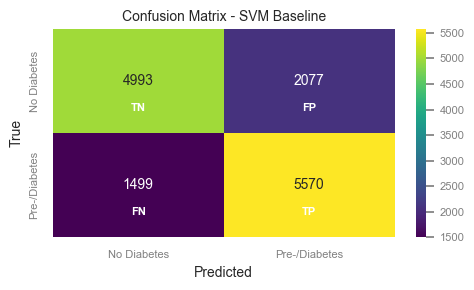


--- Generating Performance Curves ---


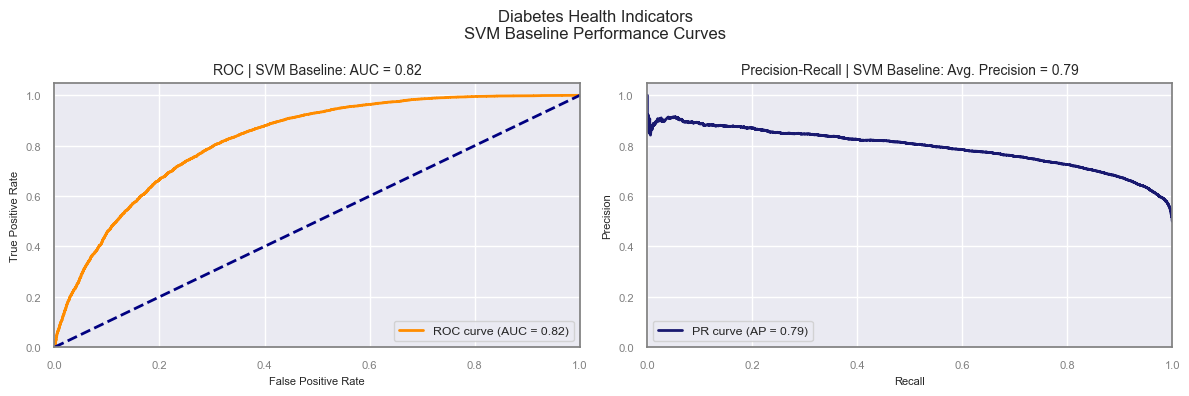

In [41]:
print("\n--- Visualizing Confusion Matrix ---")
plt.figure(figsize=(5, 3))
plot_confusion_matrix(
    y_test,
    y_pred,
    model_name   = "SVM Baseline",
    labels       = list(dict_outcome.values()),
    ax           = plt.gca()
)
plt.show()



print("\n--- Generating Performance Curves ---")

plt.figure(figsize = (12, 4))

# Plot 1: ROC AUC Curve using the enhanced function
plt.subplot(1, 2, 1)
plt.suptitle(f"{dataset_3a}\nSVM Baseline Performance Curves", fontsize=12)
plot_roc_auc_curve(
    svm_model,
    X_test_final,
    y_test,
    title   = f'ROC | SVM Baseline',
    ax      = plt.gca()
)

# Plot 2: Precision-Recall curve using the enhanced function
plt.subplot(1, 2, 2)
plot_precision_recall_curve(
    svm_model,
    X_test_final,
    y_test,
    title   = f'Precision-Recall | SVM Baseline',
    ax      = plt.gca()
)

plt.tight_layout()
plt.show()

### SVM: Pipeline +  5-fold CV

In [57]:

# --- Build the SVM Classification Pipeline ---
# preprocessing step using ColumnTransformer
# Numeric columns will be scaled (StandardScaler), others will be left as is (passthrough)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', 'passthrough', categorical_cols)
    ],
    # Drop any columns not explicitly listed in numeric_cols or categorical_cols
    remainder='drop'
)

# Define the full pipeline: Preprocessor -> SVM Classifier
#  start with  linear kernel (SVC(kernel='linear')) to balance  performance and speed.
svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel = 'linear', 
                       random_state = random_state
                       ))
])


# Define repeated cross-validation strategy: 5 folds repeated 5 times (25 total fits)
N_SPLITS, N_REPEATS = 5, 5
print(f"\n--- Repeated Stratified K-Fold CV Setup ---")
print(f"Strategy: {N_REPEATS} repeats of {N_SPLITS}-folds ({N_SPLITS * N_REPEATS} total fits)...")

cv = RepeatedStratifiedKFold(
    n_splits        = N_SPLITS,
    n_repeats       = N_REPEATS,
    random_state    = random_state
)

start = time.time()
# ---Cross-Validation Evaluation on the Training Data ---
# Use the full SVM pipeline and the UNSEALED training data (X_train).
# The pipeline handles scaling internally for each fold, ensuring correct data flow.
print("Starting Cross-Validation on Training Data (using SVM Pipeline)...")

# Run CV using the SVM Pipeline
cv_scores = cross_val_score(
    svm_pipeline,
    X_train, # Use the UNSEALED training features
    y_train,
    cv      = cv,
    scoring = 'accuracy',
    n_jobs  = -1 # Use all available cores for speed
)

print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

# Train final pipeline on the entire UNSEALED training set (X_train)
print("Training final SVM Pipeline on full training set...")
svm_pipeline.fit(X_train, y_train)

# Predict on the hold-out UNSEALED test set (X_test)
y_pred          = svm_pipeline.predict(X_test)

end             = time.time()
execution_time  = format_hms(end - start)
time_stamp      = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Execution Time: {execution_time}\n")

accuracy        = accuracy_score(y_test, y_pred)
print(f"Final Test Accuracy: {accuracy:.4f}\n")

precision       = precision_score(y_test, y_pred)
recall          = recall_score(y_test, y_pred)
f1              = f1_score(y_test, y_pred)
f1_macro        = f1_score(y_test, y_pred, average='macro')
f1_weighted     = f1_score(y_test, y_pred, average='weighted')

conf_matrix_CV  = confusion_matrix(y_test, y_pred)
cm_df_CV        = pd.DataFrame(conf_matrix_CV, index=dict_outcome.values(), columns=dict_outcome.values())
print("Confusion Matrix\n", cm_df_CV, "\n")

class_report_CV = classification_report(y_test, y_pred, target_names=dict_outcome.values())
print("Classification Report\n", class_report_CV)

results_diab_SVM_pipeline_CV = {
    'Dataset': dataset_3a,
    'Model': 'diab_SVM_pipeline_CV',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'f1': f1,
    'f1_macro': f1_macro,
    'f1_weighted': f1_weighted,
    'Execution Time': execution_time,
    'Time Stamp': time_stamp,
    'Classification Report': class_report_CV
}



--- Repeated Stratified K-Fold CV Setup ---
Strategy: 5 repeats of 5-folds (25 total fits)...
Starting Cross-Validation on Training Data (using SVM Pipeline)...
Mean CV Accuracy: 0.7485
Standard Deviation: 0.0034
Training final SVM Pipeline on full training set...
Execution Time: 00:06:35

Final Test Accuracy: 0.7471

Confusion Matrix
                No Diabetes  Pre-/Diabetes
No Diabetes           4993           2077
Pre-/Diabetes         1499           5570 

Classification Report
                precision    recall  f1-score   support

  No Diabetes       0.77      0.71      0.74      7070
Pre-/Diabetes       0.73      0.79      0.76      7069

     accuracy                           0.75     14139
    macro avg       0.75      0.75      0.75     14139
 weighted avg       0.75      0.75      0.75     14139



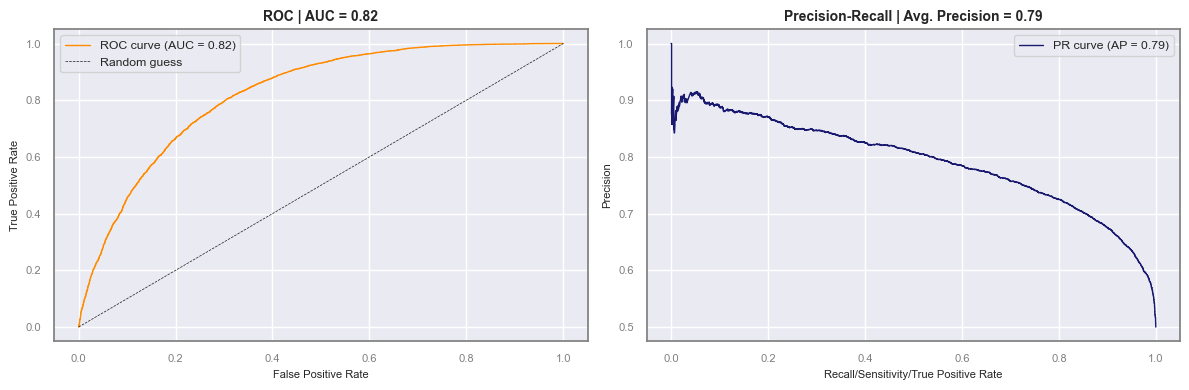

In [58]:

# Get decision function scores
y_scores = svm_pipeline.decision_function(X_test)

# Compute ROC curve and ROC AUC
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc     = auc(fpr, tpr)

# Compute Precision-Recall curve and average precision
precision, recall, _ = precision_recall_curve(y_test, y_scores)
avg_precision        = average_precision_score(y_test, y_scores)

#  ROC curve
plt.figure(figsize   = (12, 4))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='darkorange', linewidth = 1)
plt.plot([0, 1], [0, 1], 'k--', label = 'Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC | AUC = {roc_auc:.2f}', fontweight='bold')
plt.legend()

#  Precision-Recall curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label = f'PR curve (AP = {avg_precision:.2f})', linewidth = 1, color='midnightblue')
plt.xlabel('Recall/Sensitivity/True Positive Rate')
plt.ylabel('Precision')
plt.title(f'Precision-Recall | Avg. Precision = {avg_precision:.2f}', fontweight='bold')
plt.legend()

plt.tight_layout()
plt.show()


In [59]:
results_diab_SVM_pipeline_CV_df = pd.DataFrame([results_diab_SVM_pipeline_CV])
results_diab_SVM_pipeline_CV_df

,Dataset,Model,Accuracy,Precision,Recall,f1,f1_macro,f1_weighted,Execution Time,Time Stamp,Classification Report
0,Diabetes Health Indicators,diab_SVM_pipeline_CV,0.747083,0.72839,0.787947,0.756999,0.746661,0.74666,00:06:35,2025-10-21 19:37:08,precision recall f1-score ...


### SVM: Pipeline + 5-fold CV + RBF

In [18]:
# Define the full pipeline: Preprocessor -> SVM Classifier
# ACTION: Switched the kernel from 'linear' to 'rbf' for non-linear separation.
svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel = 'rbf', random_state = random_state, probability = False))
])


# --- 5. Advanced Cross-Validation Strategy ---

# Define repeated cross-validation strategy: 5 folds repeated 5 times (25 total fits)
N_SPLITS, N_REPEATS = 5, 5
print(f"\n--- Repeated Stratified K-Fold CV Setup ---")
print(f"Strategy: {N_REPEATS} repeats of {N_SPLITS}-folds ({N_SPLITS * N_REPEATS} total fits)...")

cv = RepeatedStratifiedKFold(
    n_splits        = N_SPLITS,
    n_repeats       = N_REPEATS,
    random_state    = random_state
)

# --- 6. Cross-Validation Evaluation on the Training Data ---
start = time.time()

print("Starting Cross-Validation on Training Data (using RBF SVM Pipeline)...")

# Run CV using the SVM Pipeline
start_cv    = time.time()
cv_scores   = cross_val_score(
    svm_pipeline,
    X_train, # Use the UNSEALED training features
    y_train,
    cv      = cv,
    scoring = 'accuracy',
    n_jobs  = -1 # Use all available cores for speed
)
end_cv = time.time()
print(f"CV Execution Time: {format_hms(end_cv - start_cv)}")

print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")


# --- 7. Model Training and Evaluation on Hold-Out Test Set ---

# Train the final pipeline on the entire UNSEALED training set (X_train)
print("Training final RBF SVM Pipeline on full training set...")
svm_pipeline.fit(X_train, y_train)

end  = time.time()
execution_time  = format_hms(end - start)
print(f"Execution Time: {execution_time}")

# Predict on the hold-out UNSEALED test set (X_test)
y_pred = svm_pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Final Test Accuracy: {accuracy:.4f}\n")

conf_matrix_CV_RBF  = confusion_matrix(y_test, y_pred)
cm_df_CV_RBF        = pd.DataFrame(conf_matrix_CV_RBF, index=dict_outcome.values(), columns=dict_outcome.values())
print("Confusion Matrix\n", cm_df_CV_RBF, "\n")

class_report_CV_RBF = classification_report(y_test, y_pred, target_names=dict_outcome.values())
print("Classification Report\n", class_report_CV_RBF)


# --- 8. Model Visualization (ROC AUC and Precision-Recall) ---

# Get decision function scores (used instead of predict_proba when probability=False)
y_scores = svm_pipeline.decision_function(X_test)

# Compute ROC curve and ROC AUC
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc     = auc(fpr, tpr)

# Compute Precision-Recall curve and average precision
precision, recall, _ = precision_recall_curve(y_test, y_scores)
avg_precision        = average_precision_score(y_test, y_scores)

print("\n--- Generating Model Visualization ---")

# Plot ROC curve
plt.figure(figsize   = (12, 4))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='darkorange', linewidth = 1)
plt.plot([0, 1], [0, 1], 'k--', label = 'Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC | AUC = {roc_auc:.2f}', fontweight='bold')
plt.legend()

# Plot Precision-Recall curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label = f'PR curve (AP = {avg_precision:.2f})', linewidth = 1, color='midnightblue')
plt.xlabel('Recall/Sensitivity/True Positive Rate')
plt.ylabel('Precision')
plt.title(f'Precision-Recall | Avg. Precision = {avg_precision:.2f}', fontweight='bold')
plt.legend()

plt.tight_layout()
plt.show()



--- Repeated Stratified K-Fold CV Setup ---
Strategy: 5 repeats of 5-folds (25 total fits)...
Starting Cross-Validation on Training Data (using RBF SVM Pipeline)...
CV Execution Time: 00:23:58
Mean CV Accuracy: 0.7529
Standard Deviation: 0.0036
Training final RBF SVM Pipeline on full training set...
Execution Time: 00:34:58


KeyboardInterrupt: 

### SVM: Pipeline + 5-fold + RBF + GridSearchCV

In [ ]:
# # Define the base pipeline (RBF kernel, no probability)
# base_svm_pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('classifier', SVC(kernel = 'rbf', random_state = random_state, probability = False))
# ])

# # Define the hyperparameter search grid for the RBF kernel
# param_grid = {
#     # C: Penalty parameter C of the error term (Regularization)
#     'classifier__C': [0.1, 1, 10],
#     # gamma: Kernel coefficient for 'rbf' (How far the influence of a single training example reaches)
#     'classifier__gamma': ['scale', 0.1, 1]
# }

# # --- 5. Advanced Cross-Validation Strategy ---

# # Define repeated cross-validation strategy: 5 folds repeated 5 times (25 total fits)
# N_SPLITS, N_REPEATS = 5, 5
# print(f"\n--- Hyperparameter Tuning Setup (GridSearchCV) ---")
# print(f"C values: {param_grid['classifier__C']}")
# print(f"Gamma values: {param_grid['classifier__gamma']}")
# print(f"CV Strategy: {N_REPEATS} repeats of {N_SPLITS}-folds ({N_SPLITS * N_REPEATS} fits per parameter set)")
# print(f"Total Model Fits: {len(param_grid['classifier__C']) * len(param_grid['classifier__gamma']) * N_SPLITS * N_REPEATS} (WARNING: This might take a while....)")

# cv = RepeatedStratifiedKFold(
#     n_splits        = N_SPLITS,
#     n_repeats       = N_REPEATS,
#     random_state    = random_state
# )

# # --- 6. Grid Search and Cross-Validation ---
# print("\nStarting Grid Search with Repeated CV on Training Data...")
# start_cv = time.time()

# # Set up GridSearchCV
# grid_search = GridSearchCV(
#     estimator       = base_svm_pipeline,
#     param_grid      = param_grid,
#     scoring         = 'accuracy',
#     n_jobs          = -1, # Use all available cores
#     cv              = cv,
#     verbose         = 2
# )

# # Fit the Grid Search object (training 225 models total)
# grid_search.fit(X_train, y_train)

# # Extract best results
# best_score          = grid_search.best_score_
# best_params         = grid_search.best_params_
# best_svm_pipeline   = grid_search.best_estimator_

# print(f"\n--- Best Hyperparameter Results ---")
# print(f"Best CV Mean Accuracy: {best_score:.4f}")
# print(f"Best Parameters: {best_params}")


# # --- 7. Final Model Evaluation on Hold-Out Test Set ---

# # Train the final pipeline on the entire UNSEALED training set (X_train)
# print("\nTraining final OPTIMIZED RBF SVM Pipeline on full training set...")

# # Predict on the hold-out UNSEALED test set (X_test)
# y_pred = best_svm_pipeline.predict(X_test)

# end_cv              = time.time()
# execution_time_cv = format_hms(end_cv - start_cv)
# print(f"Execution Time: {execution_time_cv}")

# accuracy            = accuracy_score(y_test, y_pred)
# print(f"Final Test Accuracy (Optimized Model): {accuracy:.4f}\n")

# # Print the Confusion Matrix
# conf_matrix_GS_RBF  = confusion_matrix(y_test, y_pred)
# cm_df_GS_RBF        = pd.DataFrame(conf_matrix_GS_RBF, index=dict_outcome.values(), columns=dict_outcome.values())
# print("Confusion Matrix (Optimized Model)\n", cm_df_GS_RBF, "\n")

# # Print the Classification Report
# class_report_GS_RBF = classification_report(y_test, y_pred, target_names=dict_outcome.values())
# print("Classification Report (Optimized Model)\n", class_report_GS_RBF)


# # VISUALIZATION: Confusion Matrix
# print("\n--- Visualizing Confusion Matrix ---")
# plt.figure(figsize=(6, 5))
# plot_confusion_matrix(
#     y_test,
#     y_pred,
#     model_name   = "Optimized RBF SVM",
#     labels       = list(dict_outcome.values()),
#     ax           = plt.gca()
# )
# plt.show()


# # --- 8. Model Visualization (ROC AUC and Precision-Recall) ---

# print("\n--- Generating Performance Curves ---")

# plt.figure(figsize = (12, 4))

# # Plot 1: ROC AUC Curve using the enhanced function
# plt.subplot(1, 2, 1)
# plot_roc_auc_curve(
#     best_svm_pipeline,
#     X_test,
#     y_test,
#     title   = f'ROC | Optimized RBF',
#     ax      = plt.gca()
# )

# # Plot 2: Precision-Recall curve using the enhanced function
# plt.subplot(1, 2, 2)
# plot_precision_recall_curve(
#     best_svm_pipeline,
#     X_test,
#     y_test,
#     title   = f'Precision-Recall | Optimized RBF',
#     ax      = plt.gca()
# )

# plt.tight_layout()
# plt.show()

### SVM: Pipeline + 5-fold CV + Polynomial kernel + GridSearchCV

In [66]:
# Define the base pipeline (POLYNOMIAL kernel, no probability)
# We use coef0 and gamma default values for simplicity in this initial search.
base_svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel       = 'poly', 
                       random_state = random_state, 
                       probability  = False)
                       )
])

# Define the hyperparameter search grid for the POLYNOMIAL kernel
param_grid = {
    # C: Regularization parameter
    'classifier__C': [0.1, 1], # Reduced search space due to high computation cost
    # degree: Degree of the polynomial kernel function
    'classifier__degree': [2, 3]
    # NOTE: The Polynomial kernel is much slower than RBF, so we keep the grid small.
}

# ---  Advanced Cross-Validation Strategy ---
# Define repeated cross-validation strategy: 5 folds repeated 5 times (25 total fits)
N_SPLITS, N_REPEATS = 5, 5
print(f"\n--- Polynomial Kernel Hyperparameter Tuning Setup (GridSearchCV) ---")
print(f"C values: {param_grid['classifier__C']}")
print(f"Degree values: {param_grid['classifier__degree']}")
print(f"CV Strategy: {N_REPEATS} repeats of {N_SPLITS}-folds ({N_SPLITS * N_REPEATS} fits per parameter set)")
print(f"Total Model Fits: {len(param_grid['classifier__C']) * len(param_grid['classifier__degree']) * N_SPLITS * N_REPEATS} (Total 100 fits. Expected runtime is long!)")

cv = RepeatedStratifiedKFold(
    n_splits        = N_SPLITS,
    n_repeats       = N_REPEATS,
    random_state    = random_state
)


# Logging setup
print(f"\n--- Polynomial Kernel Hyperparameter Tuning Setup (HalvingGridSearchCV) ---")
print(f"C values: {param_grid['classifier__C']}")
print(f"Degree values: {param_grid['classifier__degree']}")

total_fits = len(param_grid['classifier__C']) * len(param_grid['classifier__degree']) * N_SPLITS * N_REPEATS
print(f"CV Strategy: {N_REPEATS} repeats of {N_SPLITS}-folds ({N_SPLITS * N_REPEATS} fits per parameter set)")
print(f"Estimated Total Fits: {total_fits} (Note: HalvingGridSearchCV will reduce this)")

# HalvingGridSearchCV setup
print("\nStarting Polynomial Halving Grid Search with Repeated CV on Training Data...")
start_cv = time.time()

grid_search = HalvingGridSearchCV(
    estimator       = base_svm_pipeline,
    param_grid      = param_grid,
    scoring         = 'accuracy',
    n_jobs          = -1,
    cv              = cv,
    verbose         = 2,
    factor          = 2,  # You can adjust this for more aggressive halving
    random_state    = random_state
)

# Fit the search
grid_search.fit(X_train, y_train)
end_cv              = time.time()
execution_time_cv   = format_hms(end_cv - start_cv)
print(f"Halving Grid Search Execution Time: {execution_time_cv}")

# Extract best results
best_score        = grid_search.best_score_
best_params       = grid_search.best_params_
best_svm_pipeline = grid_search.best_estimator_

print(f"\n--- Best Polynomial Hyperparameter Results ---")
print(f"Best CV Mean Accuracy: {best_score:.4f}")
print(f"Best Parameters: {best_params}")

# Final evaluation on test set using the best found model
print("\nEvaluating Optimized POLYNOMIAL SVM Pipeline on Test Set...")
y_pred              = best_svm_pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Final Test Accuracy: {accuracy:.4f}\n")

precision       = precision_score(y_test, y_pred)
recall          = recall_score(y_test, y_pred)
f1              = f1_score(y_test, y_pred)
f1_macro        = f1_score(y_test, y_pred, average='macro')
f1_weighted     = f1_score(y_test, y_pred, average='weighted')

# Classification report
class_report_GS_POLY = classification_report(y_test, y_pred, target_names=dict_outcome.values())
print("Classification Report (Optimized Model)\n", class_report_GS_POLY)




--- Polynomial Kernel Hyperparameter Tuning Setup (GridSearchCV) ---
C values: [0.1, 1]
Degree values: [2, 3]
CV Strategy: 5 repeats of 5-folds (25 fits per parameter set)
Total Model Fits: 100 (Total 100 fits. Expected runtime is long!)

--- Polynomial Kernel Hyperparameter Tuning Setup (HalvingGridSearchCV) ---
C values: [0.1, 1]
Degree values: [2, 3]
CV Strategy: 5 repeats of 5-folds (25 fits per parameter set)
Estimated Total Fits: 100 (Note: HalvingGridSearchCV will reduce this)

Starting Polynomial Halving Grid Search with Repeated CV on Training Data...
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 14138
max_resources_: 56553
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 4
n_resources: 14138
Fitting 25 folds for each of 4 candidates, totalling 100 fits
[CV] END ............classifier__C=0.1, classifier__degree=2; total time=   3.8s
[CV] END ............classifier__C=0.1, classifier__degree=2; total time=   3.8s
[CV]

In [67]:
results_diab_SVM_pipe_Poly_GridSearchCV = {
    'Dataset': dataset_3a,
    'Model': 'diab_SVM_pipe_Poly_GridSearchCV',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'f1': f1,
    'f1_macro': f1_macro,
    'f1_weighted': f1_weighted,
    'Execution Time': execution_time_cv,
    'Time Stamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'Classification Report': class_report_GS_POLY
}


--- Generating Performance Visualizations ---


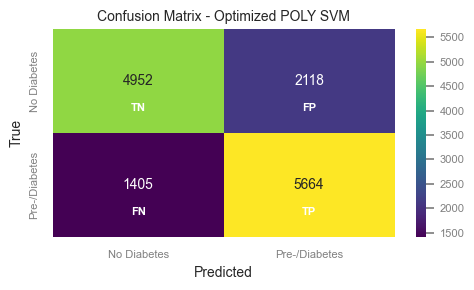

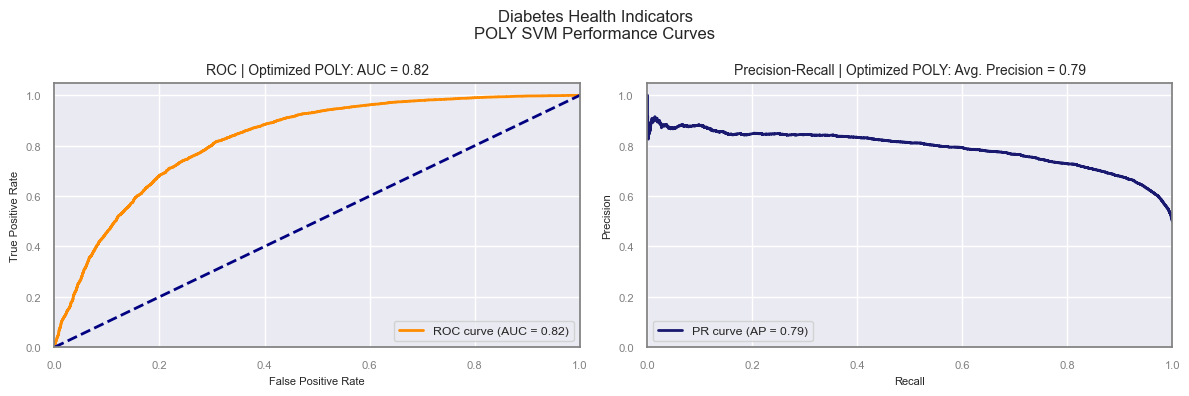

In [68]:

print("\n--- Generating Performance Visualizations ---")

# Visualization 1: Confusion Matrix
plt.figure(figsize=(5, 3))
plot_confusion_matrix(
    y_test,
    y_pred,
    model_name="Optimized POLY SVM",
    labels=list(dict_outcome.values()),
    ax=plt.gca()
)
plt.show()

# Visualization 2 & 3: ROC AUC and Precision-Recall Curves
plt.figure(figsize   = (12, 4))
plt.suptitle(f"{dataset_3a}\nPOLY SVM Performance Curves", fontsize = 12)
plt.subplot(1, 2, 1)
plot_roc_auc_curve(
    best_svm_pipeline,
    X_test,
    y_test,
    title=f'ROC | Optimized POLY',
    ax=plt.gca()
)


plt.subplot(1, 2, 2)
plot_precision_recall_curve(
    best_svm_pipeline,
    X_test,
    y_test,
    title=f'Precision-Recall | Optimized POLY',
    ax=plt.gca()
)

plt.tight_layout()
plt.show()

In [69]:
diab_SVM_pipe_Poly_GridSearchCV_df = pd.DataFrame([results_diab_SVM_pipe_Poly_GridSearchCV])
diab_SVM_pipe_Poly_GridSearchCV_df

,Dataset,Model,Accuracy,Precision,Recall,f1,f1_macro,f1_weighted,Execution Time,Time Stamp,Classification Report
0,Diabetes Health Indicators,diab_SVM_pipe_Poly_GridSearchCV,0.750831,0.727833,0.801245,0.762777,0.750198,0.750197,00:07:52,2025-10-21 20:35:47,precision recall f1-score ...


In [70]:
summary_results_diab_SVM_df = pd.concat([
    results_diab_SVM_baseline_df,
    results_diab_SVM_pipeline_CV_df,
    diab_SVM_pipe_Poly_GridSearchCV_df
], ignore_index=True)

summary_results_diab_SVM_df

,Dataset,Model,Accuracy,Precision,Recall,f1,f1_macro,f1_weighted,execution_time,time_stamp,Confusion Matrix,Classification Report,Execution Time,Time Stamp
0,Diabetes Health Indicators,diab_SVM_baseline,0.747083,0.728390,0.787947,0.756999,0.746661,0.746660,00:00:56,2025-10-21 18:57:52,"[[4993, 2077], [1499, 5570]]",precision recall f1-score ...,NaN,NaN
1,Diabetes Health Indicators,diab_SVM_pipeline_CV,0.747083,0.728390,0.787947,0.756999,0.746661,0.746660,NaN,NaN,NaN,precision recall f1-score ...,00:06:35,2025-10-21 19:37:08
2,Diabetes Health Indicators,diab_SVM_pipe_Poly_GridSearchCV,0.750831,0.727833,0.801245,0.762777,0.750198,0.750197,NaN,NaN,NaN,precision recall f1-score ...,00:07:52,2025-10-21 20:35:47


 <font color='plum'>Looks like I exhausted the predictive power of the Support Vector Machine model family for the diabetes dataset's current features. The maximum information that can be extracted using linear, RBF, or polynomial separation in a high-dimensional space is right around 75.1%.



##  <font color='plum'> 3.b. Hypertension Risk Prediction Dataset

Includes lifestyle, demographic, and clinical data (e.g., BMI, cholesterol, stress,
salt intake, smoking, family history) from individuals across multiple countries. It is
labeled for classification tasks (low vs. high risk of hypertension).
https://www.kaggle.com/datasets/ankushpanday1/hypertension-risk-prediction-dataset

### Load & Clean

In [ ]:

file_path = "ankushpanday1/hypertension-risk-prediction-dataset"
file_name = "hypertension_dataset.csv"

df_3b = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  file_path,
  file_name,
)
df_3b.columns = df_3b.columns.str.strip() 
print(df_3b.shape)
df_3b.head()

(174982, 23)


,Country,Age,BMI,Cholesterol,Systolic_BP,Diastolic_BP,Smoking_Status,Alcohol_Intake,Physical_Activity_Level,Family_History,...,Sleep_Duration,Heart_Rate,LDL,HDL,Triglycerides,Glucose,Gender,Education_Level,Employment_Status,Hypertension
0,UK,58,29.5,230,160,79,Never,27.9,Low,Yes,...,6.1,80,100,75,72,179,Female,Primary,Unemployed,High
1,Spain,34,36.2,201,120,84,Never,27.5,High,Yes,...,9.8,56,77,47,90,113,Male,Secondary,Unemployed,High
2,Indonesia,73,18.2,173,156,60,Current,1.8,High,Yes,...,5.2,75,162,56,81,101,Male,Primary,Employed,Low
3,Canada,60,20.3,183,122,94,Never,11.6,Moderate,Yes,...,7.5,71,164,93,94,199,Female,Secondary,Retired,High
4,France,73,21.8,296,91,97,Never,29.1,Moderate,Yes,...,5.0,52,108,74,226,157,Female,Primary,Employed,High


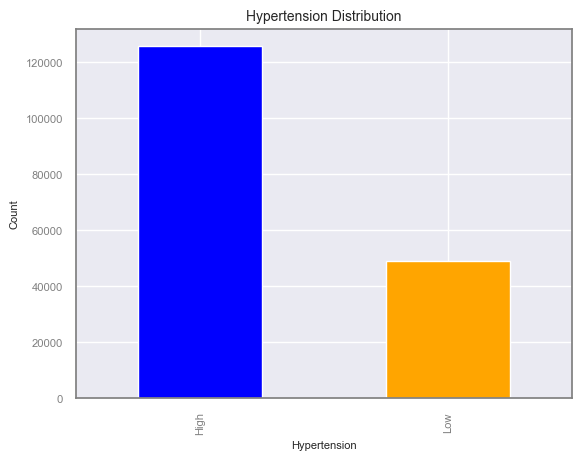

In [ ]:
# pandas plot of 'Hypertension' column
df_3b['Hypertension'].value_counts().plot(kind='bar', title='Hypertension Distribution', xlabel='Hypertension', ylabel='Count', color=['blue', 'orange'])
plt.show()

<font color='plum'>

- This is an extremely imbalanced dataset, which isn't helping matters. The model will always favor the majority class to optimize accuracy at expense of minority class

- Will explore 'f1' or 'recall' in RandomizedSearchCV to force the model to optimize for minority class performance.


In [ ]:
target_col          = 'Hypertension'
categorical_cols    = ['Country', 'Smoking_Status', 'Physical_Activity_Level', 'Family_History', 'Diabetes', 'Gender', 'Education_Level', 'Employment_Status', 'Hypertension']
numeric_cols        = ['Age', 'BMI', 'Cholesterol', 'Systolic_BP', 'Diastolic_BP', 'Alcohol_Intake', 'Stress_Level', 'Salt_Intake', 'Sleep_Duration', 'Heart_Rate', 'LDL', 'HDL', 'Triglycerides', 'Glucose']
len(categorical_cols), len(numeric_cols)

# for col in categorical_cols:
#     print(f'{col}: {df_3b[col].unique()},\n{df_3b[col].nunique()} unique values\n')

(9, 14)

In [ ]:
data = df_3b.copy()

# Dropping 'Country' column because it's fucking pointless for this analysis 
data = data.drop(columns = ['Country'])

# One-hot encode 'Smoking_Status', and 'Employment_Status' columns
data = pd.get_dummies(data, columns = ['Smoking_Status', 'Employment_Status'], drop_first = True)

cat_cols_2 = ['Physical_Activity_Level', 'Family_History', 'Diabetes', 'Gender', 'Education_Level']

for col in cat_cols_2:
    data[col] = LabelEncoder().fit_transform(data[col])

# for target column, map 'High' to 1, 'Low' to 0
data[target_col] = data[target_col].map({'High': 1, 'Low': 0})
data.head()

#export data to csv
# data.to_csv('hypertension_dataset_processed.csv', index=False)


,Age,BMI,Cholesterol,Systolic_BP,Diastolic_BP,Alcohol_Intake,Physical_Activity_Level,Family_History,Diabetes,Stress_Level,...,HDL,Triglycerides,Glucose,Gender,Education_Level,Hypertension,Smoking_Status_Former,Smoking_Status_Never,Employment_Status_Retired,Employment_Status_Unemployed
0,58,29.5,230,160,79,27.9,1,1,1,9,...,75,72,179,0,0,1,False,True,False,True
1,34,36.2,201,120,84,27.5,0,1,1,6,...,47,90,113,1,1,1,False,True,False,True
2,73,18.2,173,156,60,1.8,0,1,1,5,...,56,81,101,1,0,0,False,False,False,False
3,60,20.3,183,122,94,11.6,2,1,1,6,...,93,94,199,0,1,1,False,True,True,False
4,73,21.8,296,91,97,29.1,2,1,0,6,...,74,226,157,0,0,1,False,True,False,False


In [ ]:
random_state        = 42
test_size           = 0.2

y = data[target_col]
X = data.drop(columns = [target_col])

## <font color='plum'> 3.c. Chronic Kidney Disease Dataset

Contains comprehensive data for 1,659 patients, including 54 variables spanning medical history, lab results, medication usage, quality of life, and environmental
exposure. Ideal for regression, classification, and clustering analyses.
https://www.kaggle.com/datasets/rabieelkharoua/chronic-kidney-disease-dataset-analysis

### Load & Clean - CKD

In [45]:
file_path = "rabieelkharoua/chronic-kidney-disease-dataset-analysis"
file_name = "Chronic_Kidney_Dsease_data.csv"

dataset_3c = 'Chronic Kidney Disease Prediction'

# Load the latest version
df_3c = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  file_path,
  file_name,
)

df_3c.columns   = df_3c.columns.str.strip()
columns_to_drop = ['PatientID', 'DoctorInCharge']
df_3c.drop(columns = columns_to_drop, inplace = True, errors = 'ignore')

# --- MANDATORY CLEANING STEP 1: Feature Coercion ---
# Coerce all feature columns to numeric, turning messy text/spaces into NaN.
target_col = 'Diagnosis'
for col in df_3c.columns:
    if col != target_col: 
        # Errors='coerce' converts non-numeric text into NaN
        df_3c[col] = pd.to_numeric(df_3c[col], errors='coerce')
print("Applied robust data type coercion to feature columns.")

# --- MANDATORY CLEANING STEP 2: Target Encoding and Dropping NaNs ---
# Encode the target variable

le                = LabelEncoder()
df_3c[target_col] = le.fit_transform(df_3c[target_col])
target_labels     = [str(label) for label in le.classes_] # FIX: Ensure target_labels are strings for classification_report
print(f"Target variable '{target_col}' encoded successfully.")

# DROP ROWS WITH MISSING VALUES (The simplest form of imputation)
df_clean      = df_3c.dropna()
initial_rows  = df_3c.shape[0]
final_rows    = df_clean.shape[0]
print(f"Dropped rows with NaNs. Initial rows: {initial_rows}, Final rows: {final_rows}")
print(f"Percentage of data retained: {final_rows / initial_rows * 100:.2f}%\n")


# ---   Feature and Target Separation ---
X_df          = df_clean.drop(columns = [target_col])
y             = df_clean[target_col]

# features for manual scaling
all_features  = X_df.columns.tolist()

# --- 3. Data Splitting (80/20) ---
X_train, X_test, y_train, y_test = train_test_split(
    X_df, y, test_size = test_size, random_state = random_state, stratify = y
)
print(f"Data Split: Training set size = {X_train.shape[0]}, Test set size = {X_test.shape[0]}\n")


# ---  Manual Feature Scaling ---
print("--- Manual Feature Scaling ---")

scaler          = StandardScaler()
X_train_scaled  = scaler.fit_transform(X_train) # Fit and transform the training data
X_test_scaled   = scaler.transform(X_test)   # Transform the test data

# Convert back to DataFrames for consistency with plotting helpers
X_train_final   = pd.DataFrame(X_train_scaled, columns=all_features)
X_test_final    = pd.DataFrame(X_test_scaled, columns=all_features)

print("Scaling Complete.\n")

Applied robust data type coercion to feature columns.
Target variable 'Diagnosis' encoded successfully.
Dropped rows with NaNs. Initial rows: 1659, Final rows: 1659
Percentage of data retained: 100.00%

Data Split: Training set size = 1327, Test set size = 332

--- Manual Feature Scaling ---
Scaling Complete.



### SVM | CKD: Baseline

In [46]:
model_name = "CKD_Baseline_SVM_rbf_balanced"

# --- 5. Basic SVM Model Training and Evaluation ---
print(f"--- Training {model_name} Model ---")
start       = time.time()

# Define the SVM Classifier (basic setup)
svm_model   = SVC(kernel          ='rbf', 
                random_state    = random_state, 
                probability     = False, 
                class_weight    = 'balanced'
                )

# Train the model on the SCALED training set
svm_model.fit(X_train_final, y_train)



# Predict on the scaled test set
y_pred          = svm_model.predict(X_test_final)

end             = time.time()
execution_time  = format_hms(end - start)
time_stamp      = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Execution Time: {execution_time}\n")

# Evaluation
accuracy        = accuracy_score(y_test, y_pred)
precision       = precision_score(y_test, y_pred)
recall          = recall_score(y_test, y_pred)
f1              = f1_score(y_test, y_pred)
f1_macro        = f1_score(y_test, y_pred, average='macro')
f1_weighted     = f1_score(y_test, y_pred, average='weighted')

class_report    = classification_report(y_test, y_pred, zero_division=0, target_names=target_labels)

print(f"--- Final {model_name} Evaluation ---")
print(f"Test Accuracy: {accuracy:.4f}\n")
print("Classification Report:\n", class_report)

results_CKD_Baseline_SVM_rbf_balanced = {
    'Dataset': dataset_3c,
    'Model': model_name,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'f1': f1,
    'f1_macro': f1_macro,
    'f1_weighted': f1_weighted,
    'execution_time': execution_time,
    'time_stamp': time_stamp,
    'Classification Report': class_report
}

--- Training CKD_Baseline_SVM_rbf_balanced Model ---
Execution Time: 00:00:00

--- Final CKD_Baseline_SVM_rbf_balanced Evaluation ---
Test Accuracy: 0.9036

Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.30      0.33        27
           1       0.94      0.96      0.95       305

    accuracy                           0.90       332
   macro avg       0.66      0.63      0.64       332
weighted avg       0.89      0.90      0.90       332



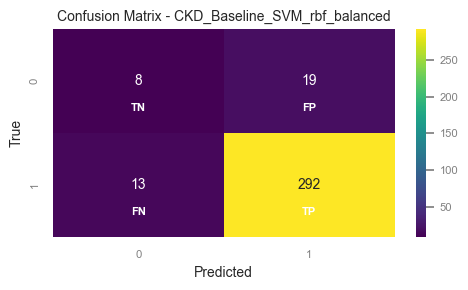

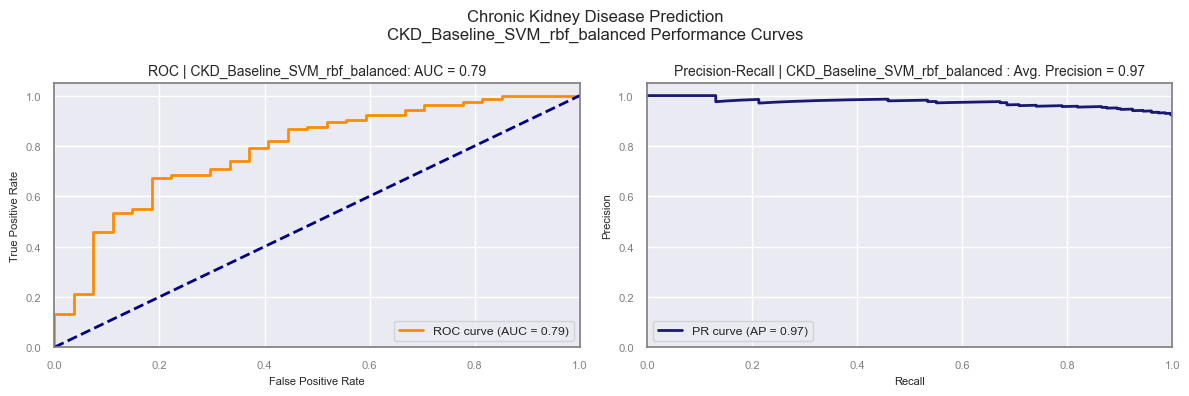

In [47]:
plt.figure(figsize=(5, 3))
plot_confusion_matrix(
    y_test,
    y_pred,
    model_name  = model_name,
    labels      = target_labels ,
    ax          = plt.gca()
)
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plt.suptitle(f"{dataset_3c}\n{model_name} Performance Curves", fontsize=12)
plot_roc_auc_curve(
    svm_model, 
    X_test_final, 
    y_test,
    title   = f'ROC | {model_name}',
    ax      = ax[0] 
)

plot_precision_recall_curve(
    svm_model, 
    X_test_final, 
    y_test,
    title   = f'Precision-Recall | {model_name} ',
    ax      = ax[1] 
)

plt.tight_layout()
plt.show()

In [48]:
CKD_Baseline_SVM_rbf_balanced_df = pd.DataFrame([results_CKD_Baseline_SVM_rbf_balanced])
CKD_Baseline_SVM_rbf_balanced_df

,Dataset,Model,Accuracy,Precision,Recall,f1,f1_macro,f1_weighted,execution_time,time_stamp,Classification Report
0,Chronic Kidney Disease Prediction,CKD_Baseline_SVM_rbf_balanced,0.903614,0.938907,0.957377,0.948052,0.640693,0.89806,00:00:00,2025-10-21 19:23:42,precision recall f1-score ...


### SVM | CKD Baseline w/ GridSearchCV

In [49]:
model_name = "CKD_SVM_rbf_balanced_GridSearchCV"   

 # --- RBF SVM Grid Search for Optimal C and Gamma ---
print(f"--- Starting {model_name} Grid Search ---")
start = time.time()

#  Define the model (Balanced RBF SVM)
svm_base = SVC(kernel = 'rbf',
            random_state    = random_state, 
            probability     = False, 
            class_weight    = 'balanced'
            )

#   Define the parameter grid
#  target C and gamma to shift the precision/recall balance
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.1, 1]
}

#  cross-validation strategy
cv = RepeatedStratifiedKFold(n_splits       = 5, 
                             n_repeats      = 10, 
                             random_state   = random_state
                             )

# Define the Grid Search object
# 'f1_macro' as the scoring metric because it balances performance on both imbalanced classes.
grid_search = GridSearchCV(
    estimator   = svm_base,
    param_grid  = param_grid,
    scoring     = 'f1_macro', 
    cv          = cv,
    n_jobs      = -1,
    verbose     = 1
)

# Run the search on the scaled training data
grid_search.fit(X_train_final, y_train)

end             = time.time()
execution_time  = format_hms(end - start)
time_stamp      = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Grid Search Execution Time: {execution_time}\n")

# --- 6. Final Model Evaluation ---

# Get the best model
best_svm_model  = grid_search.best_estimator_
y_pred          = best_svm_model.predict(X_test_final)

# Evaluation
accuracy        = accuracy_score(y_test, y_pred)
class_report    = classification_report(y_test, y_pred, 
                                        zero_division   = 0, 
                                        target_names    = target_labels
                                        )

precision       = precision_score(y_test, y_pred)
recall          = recall_score(y_test, y_pred)
f1              = f1_score(y_test, y_pred)
f1_macro        = f1_score(y_test, y_pred, average='macro')
f1_weighted     = f1_score(y_test, y_pred, average='weighted')



print(f"--- Best Hyperparameter Results ---")
print(f"Best CV Score (F1-Macro): {grid_search.best_score_:.4f}")
print(f"Best Parameters: {grid_search.best_params_}")

print(f"\n--- Final Optimized Model Evaluation (Test Set) ---")
print(f"Test Accuracy: {accuracy:.4f}\n")
print("Classification Report:\n", class_report)


results_CKD_SVM_rbf_balanced_GridSearchCV = {
    'Dataset': dataset_3c,
    'Model': model_name,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'f1': f1,
    'f1_macro': f1_macro,
    'f1_weighted': f1_weighted,
    'execution_time': execution_time,
    'time_stamp': time_stamp,
    'Classification Report': class_report
}


--- Starting CKD_SVM_rbf_balanced_GridSearchCV Grid Search ---
Fitting 50 folds for each of 12 candidates, totalling 600 fits
Grid Search Execution Time: 00:00:06

--- Best Hyperparameter Results ---
Best CV Score (F1-Macro): 0.6293
Best Parameters: {'C': 0.1, 'gamma': 'scale'}

--- Final Optimized Model Evaluation (Test Set) ---
Test Accuracy: 0.7771

Classification Report:
               precision    recall  f1-score   support

           0       0.21      0.63      0.31        27
           1       0.96      0.79      0.87       305

    accuracy                           0.78       332
   macro avg       0.59      0.71      0.59       332
weighted avg       0.90      0.78      0.82       332



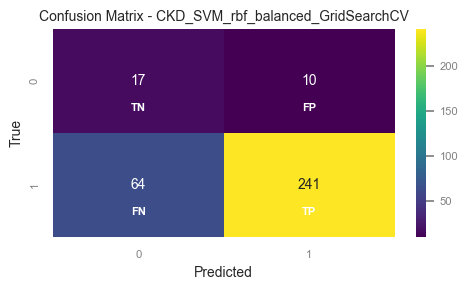

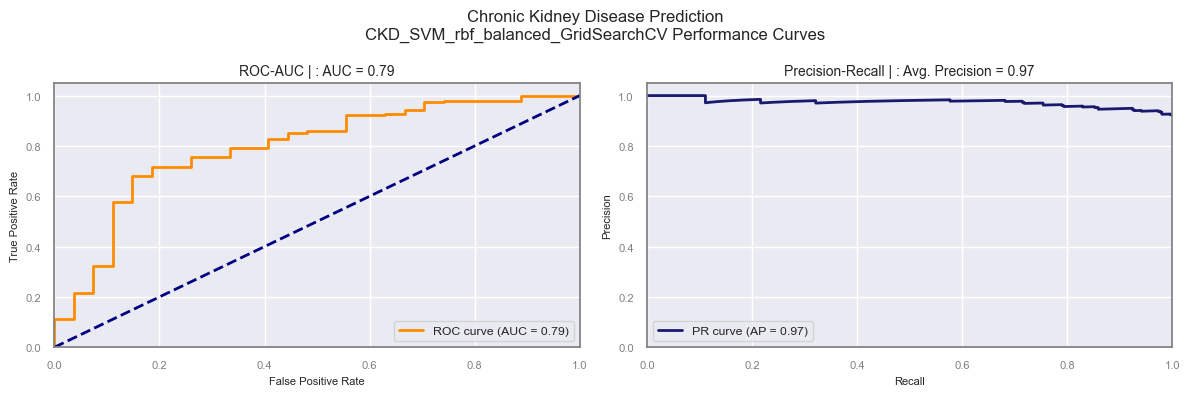

In [51]:
plot_confusion_matrix(
    y_test,
    y_pred,
    model_name  = f"{model_name}",
    labels      = target_labels, 
)
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plt.suptitle(f"{dataset_3c}\n{model_name} Performance Curves", fontsize=12)
plot_roc_auc_curve(
    best_svm_model, 
    X_test_final, 
    y_test,
    title   = f'ROC-AUC | ',
    ax      = ax[0] 
)


plot_precision_recall_curve(
    best_svm_model, 
    X_test_final, 
    y_test,
    title   = f'Precision-Recall | ',
    ax      = ax[1] 
)

plt.tight_layout()
plt.show()

In [52]:
CKD_SVM_rbf_balanced_GridSearchCV_df = pd.DataFrame([results_CKD_SVM_rbf_balanced_GridSearchCV])
CKD_SVM_rbf_balanced_GridSearchCV_df

,Dataset,Model,Accuracy,Precision,Recall,f1,f1_macro,f1_weighted,execution_time,time_stamp,Classification Report
0,Chronic Kidney Disease Prediction,CKD_SVM_rbf_balanced_GridSearchCV,0.777108,0.960159,0.790164,0.866906,0.590861,0.822007,00:00:06,2025-10-21 19:25:23,precision recall f1-score ...


In [53]:
summary_results_CKD_SVM_df = pd.concat([
    CKD_Baseline_SVM_rbf_balanced_df, 
    CKD_SVM_rbf_balanced_GridSearchCV_df
], ignore_index=True)
summary_results_CKD_SVM_df

,Dataset,Model,Accuracy,Precision,Recall,f1,f1_macro,f1_weighted,execution_time,time_stamp,Classification Report
0,Chronic Kidney Disease Prediction,CKD_Baseline_SVM_rbf_balanced,0.903614,0.938907,0.957377,0.948052,0.640693,0.898060,00:00:00,2025-10-21 19:23:42,precision recall f1-score ...
1,Chronic Kidney Disease Prediction,CKD_SVM_rbf_balanced_GridSearchCV,0.777108,0.960159,0.790164,0.866906,0.590861,0.822007,00:00:06,2025-10-21 19:25:23,precision recall f1-score ...


## Summary

In [71]:
summary_week5_diab_CKD_SVM_df = pd.concat([
    summary_results_diab_SVM_df,
    summary_results_CKD_SVM_df
], ignore_index=True)
summary_week5_diab_CKD_SVM_df

,Dataset,Model,Accuracy,Precision,Recall,f1,f1_macro,f1_weighted,execution_time,time_stamp,Confusion Matrix,Classification Report,Execution Time,Time Stamp
0,Diabetes Health Indicators,diab_SVM_baseline,0.747083,0.728390,0.787947,0.756999,0.746661,0.746660,00:00:56,2025-10-21 18:57:52,"[[4993, 2077], [1499, 5570]]",precision recall f1-score ...,NaN,NaN
1,Diabetes Health Indicators,diab_SVM_pipeline_CV,0.747083,0.728390,0.787947,0.756999,0.746661,0.746660,NaN,NaN,NaN,precision recall f1-score ...,00:06:35,2025-10-21 19:37:08
2,Diabetes Health Indicators,diab_SVM_pipe_Poly_GridSearchCV,0.750831,0.727833,0.801245,0.762777,0.750198,0.750197,NaN,NaN,NaN,precision recall f1-score ...,00:07:52,2025-10-21 20:35:47
3,Chronic Kidney Disease Prediction,CKD_Baseline_SVM_rbf_balanced,0.903614,0.938907,0.957377,0.948052,0.640693,0.898060,00:00:00,2025-10-21 19:23:42,NaN,precision recall f1-score ...,NaN,NaN
4,Chronic Kidney Disease Prediction,CKD_SVM_rbf_balanced_GridSearchCV,0.777108,0.960159,0.790164,0.866906,0.590861,0.822007,00:00:06,2025-10-21 19:25:23,NaN,precision recall f1-score ...,NaN,NaN


<font color='cyan'>

The Trade-Off: 
- Accuracy for Sensitivity: drop in overall accuracy from 90% to 78% is a direct consequence of the successful tuning.

The Change: 
- Grid Search correctly found a better set of parameters (by lowering C to 0.1), which made the model smoother and more conservative.

The Goal Achieved: 
- `f1_macro` scoring metric, which **prioritizes performance on the minority class**. The model correctly responded by increasing the Recall for Class 0 (the disease) from 30% to 63%. This means the model is now more than twice as likely to catch a positive CKD case.

The Cost: 
- This sensitivity comes at a steep price: Precision for Class 0 fell to 0.21, meaning for every 10 predictions the model makes for "Disease Present," it is only correct about 2 of them (8 are False Positives).

In a medical context, 63% Recall is often preferred over a biased 30% Recall, but 21% Precision is still too low for certainty.

## Notes

SVM is a **supervised machine learning algorithm** used for **classification** and **regression** tasks. It tries to find the **optimal hyperplane** that best separates classes in the feature space.

#### Hyperplane
In an *n*-dimensional space, a **hyperplane** is a flat affine subspace of dimension *n-1* that divides the data points into classes.

#### Maximal Margin
SVM aims to find the hyperplane with the **maximum margin**, i.e., the greatest distance between the hyperplane and the nearest data points from either class (called **support vectors**).

#### Support Vectors
The data points **closest to the hyperplane** that influence its position and orientation are called **support vectors**. They are critical in defining the decision boundary.

#### Types of Data
- Linearly Separable Data
For linearly separable data, SVM finds a hyperplane that **perfectly separates** the classes with the **maximal margin**.

- Non-linearly Separable Data. When data isn’t linearly separable, SVM uses:

  - **Kernel Trick**: Maps input features into higher-dimensional space to make them linearly separable.
    - Common kernels include:
      - Linear
      - Polynomial
      - Radial Basis Function (RBF)
      - Sigmoid

  - **Soft Margin SVM**: Introduces slack variables to allow some **misclassification** or **margin violations** to handle noisy data or non-perfect separability, balancing **margin maximization** and **error minimization**.

#### Advantages of SVMs
- Effective in **high-dimensional spaces**
- Works well when the number of **features > samples**
- Robust against **overfitting** when properly regularized

#### Limitations
- **Computationally intensive** for very large datasets
- Choosing the right **kernel** and tuning parameters like **C** (regularization) and **gamma** (kernel coefficient) can be challenging

### <font color = 'gold'> *Regularization*

<font color = 'plum'>

Sometimes, we have to balance two different goals: 
* Making the margin large. 
* Ensuring that most or all points are outside the margin on both sides of the decision boundary. 

For example, suppose we have a situation where the margin is tiny — there's just a thin margin between the two classes — but the data is otherwise perfectly divided. However, suppose the margin is forced to be thin because of just two or three points out of millions. If it weren’t for those two or three points, the margin would be much larger. In that case, we might opt to make the margin large, even if those two or three points would be ignored. 

On the other hand, if the margin is narrow because there are thousands of points on either side of the decision boundary that are close together, then we might choose to keep the margin narrow. 

SVMs have a regularization parameter ﻿C﻿ just like linear regression does. Larger values of ﻿C﻿ try to classify all points correctly. Smaller values try to make the margin large. 

### <font color = 'gold'> *Radial Basis Function (RBF)*

<font color = 'plum'>

The RBF Kernel Explained
RBF stands for Radial Basis Function. In simple terms, it is a mathematical function used in SVMs that defines a curved boundary to separate data points.

1. The Core Problem (The "Kernel Trick")
A standard Linear SVM can only separate data that is linearly separable (meaning you can draw a straight line or flat plane between the classes).

However, most real-world data (like the CKD data) isn't linearly separable.

The Kernel Trick is the solution. It involves mathematically transforming the original low-dimensional data (e.g., 2D) into a higher-dimensional space (e.g., 3D or much higher). In this higher dimension, the data that was inseparable with a straight line in 2D often becomes linearly separable with a flat plane in the new dimension.

2. How the RBF Kernel Works
The RBF kernel is the most popular function for performing this transformation. It essentially measures the similarity between data points.

Mapping: The RBF kernel maps the data into an infinite-dimensional space.

Similarity: It defines a boundary that is circular or spherical around the data points. If a new data point is close enough to the cluster center of one class (i.e., highly similar), it is classified as belonging to that class.

Non-Linearity: This results in a complex, curved decision boundary when projected back into the original 2D or 3D feature space, allowing the SVM to separate classes that are intertwined.

Key Parameter: Gamma (γ)
The RBF kernel is controlled by the hyperparameter gamma (γ):

High Gamma: Causes the decision boundary to be very tight and follow every little curve in the training data, leading to a high risk of overfitting.

Low Gamma: Creates a smoother, broader decision boundary, leading to a higher risk of underfitting but better generalization.

The goal of your RBF Grid Search was to find the optimal balance for C and γ to get the best curved boundary possible.


### <font color='gold'><i>Is it possible to be sure that the margin on one side of the hyperplane equals the margin on the other side? (Hint: We are allowed to move the hyperplane.)</i>

<font color='plum'>
Yes, it's possible to be sure that the margin on one side of the hyperplane equals the margin on the other side. This is a fundamental concept in Support Vector Machines (SVMs).

**Understanding the Optimal Hyperplane**

The goal of an SVM is to find the **optimal hyperplane** that separates data points belonging to different classes. This hyperplane is defined as the one that maximizes the distance to the **nearest data points** of each class. These nearest points are called the **support vectors**.

The distance from the hyperplane to the nearest data point on one side is the **positive margin**, and the distance to the nearest data point on the other side is the **negative margin**.

**Maximizing the Margin**
To maximize the overall margin, the hyperplane must be positioned **exactly in the middle** of the two classes' support vectors. This is achieved by adjusting both the hyperplane's orientation and its position. Since the goal is to maximize the separation between the closest points of the two classes, the most logical and effective way to do this is to place the hyperplane exactly midway between them.

Because the optimal hyperplane is positioned to bisect the distance between the two sets of support vectors, the margin on the positive side will, by definition, be equal to the margin on the negative side. This symmetrical placement ensures that the hyperplane is as far as possible from the data points of both classes, which is the core objective of the SVM algorithm. 


---
### <font color='gold'><i>Compute the polynomial kernel for vectors of dimension 2 (smaller than the example, which is dimension 3). Use `c = 0`. This is the simplest possible polynomial kernel that isn’t trivial. Find the vectors whose inner product is equal to `(xTz)^2` </i>

<font color='plum'> 

##### 1. Polynomial Kernel for 2D Vectors (Degree 2, \( c = 0 \))

The **polynomial kernel** is defined as:

$$
K(\mathbf{x}, \mathbf{z}) = (\mathbf{x}^\top \mathbf{z} + c)^d
$$

For this example:
- Vector dimension: 2
- Degree \( d = 2 \)
- Constant \( c = 0 \)

So the kernel simplifies to:

$$
K(\mathbf{x}, \mathbf{z}) = (\mathbf{x}^\top \mathbf{z})^2
$$

##### 2. Compute the Kernel


$$
\mathbf{x}^\top \mathbf{z} = x_1 z_1 + x_2 z_2
$$

So:

$$
K(\mathbf{x}, \mathbf{z}) = (x_1 z_1 + x_2 z_2)^2
$$

Expanding:

$$
K(\mathbf{x}, \mathbf{z}) = x_1^2 z_1^2 + 2 x_1 x_2 z_1 z_2 + x_2^2 z_2^2
$$


##### 3. Feature Mapping \( \phi(\cdot) \)

We want to find a mapping \( \phi(\cdot) \) such that:

$$
K(\mathbf{x}, \mathbf{z}) = \langle \phi(\mathbf{x}), \phi(\mathbf{z}) \rangle
$$

Define:

$$
\phi(\mathbf{x}) = 
\begin{bmatrix}
x_1^2 \\
\sqrt{2} x_1 x_2 \\
x_2^2
\end{bmatrix}, \quad
\phi(\mathbf{z}) = 
\begin{bmatrix}
z_1^2 \\
\sqrt{2} z_1 z_2 \\
z_2^2
\end{bmatrix}
$$

Then:

$$
\langle \phi(\mathbf{x}), \phi(\mathbf{z}) \rangle = x_1^2 z_1^2 + 2 x_1 x_2 z_1 z_2 + x_2^2 z_2^2 = (x_1 z_1 + x_2 z_2)^2
$$

 **Confirmed!** The polynomial kernel \( (\mathbf{x}^\top \mathbf{z})^2 \) is the inner product of the transformed vectors  `phi(x)`and `phi(z)` in a 3D feature space.


##### Summary

- The polynomial kernel \( (\mathbf{x}^\top \mathbf{z})^2 \) maps 2D vectors into a 3D feature space.
- The feature mapping is:

  $$
  \phi(\mathbf{x}) = [x_1^2, \sqrt{2} x_1 x_2, x_2^2]^\top
  $$

- This transformation allows SVMs to find a **linear separator** in the higher-dimensional space, enabling classification of data that is **not linearly separable** in the original space.

--- 

### <font color='gold'><i>How can we tell that the Gaussian kernel `K(x,z)` is not simply the inner product of `x` with `z`? Is it easy to find some other vectors of which it is the inner product?</i></font>

<font color='plum'>

The *Gaussian kernel* (also known as the **RBF kernel**) is defined as:

$$
K(\mathbf{x}, \mathbf{z}) = \exp\left(-\frac{\|\mathbf{x} - \mathbf{z}\|^2}{2\sigma^2}\right)
$$

This kernel measures the similarity between two vectors `x` and `z`, and it decays exponentially with the squared Euclidean distance between them.


#### Is the Gaussian Kernel an Inner Product?  

No, the Gaussian kernel is **not** simply the inner product of `x` and `z` because:

- The standard **inner product** in Euclidean space is linear:  
  $$
  \langle \mathbf{x}, \mathbf{z} \rangle = \sum_i x_i z_i
  $$

- The **Gaussian kernel** is **non-linear** and involves an exponential of the squared distance between vectors. It doesn't satisfy the properties of a standard inner product in the input space.

#### Is the Gaussian Kernel an Inner Product in Some Other Space?

- The Gaussian kernel **is** an inner product in an **infinite-dimensional Hilbert space**. That is, there exists a mapping \( \phi: \mathbb{R}^n \rightarrow \mathcal{H} \) into a high (in fact, infinite) dimensional space such that:

  $$
  K(\mathbf{x}, \mathbf{z}) = \langle \phi(\mathbf{x}), \phi(\mathbf{z}) \rangle_{\mathcal{H}}
  $$

- This is the essence of the **kernel trick**: you can compute the inner product in this high-dimensional space without explicitly computing  `phi(x)`and `phi(z)`.

#### Can We Find the Vectors  `phi(x)`and `phi(z)`?

Not easily. The mapping \( \phi \) for the Gaussian kernel involves an **infinite series expansion**, which means the feature space is infinite-dimensional. So while such vectors exist in theory, we **cannot explicitly write them down** in a finite form.

However, we can approximate them using techniques like:

- **Random Fourier Features**: Approximate the Gaussian kernel by mapping inputs to a finite-dimensional space using random projections.
- **Nyström Method**: Another approximation technique using a subset of the data.

####

- The Gaussian kernel is **not** a simple inner product in the input space.
- It **is** an inner product in an **infinite-dimensional feature space**.
- Finding the exact vectors  `phi(x)`and `phi(z)` is **not easy**, but **approximate representations** exist.

----

### <font color='gold'>*Why might maximizing the margin in an SVM model help improve how well it classifies new data?*</font>

<font color='plum'>

Support Vector Machines (SVMs) aim to find the **optimal separating hyperplane** between classes in a dataset. One of the key principles behind SVMs is **maximizing the margin**, which is the distance between the hyperplane and the nearest data points from each class (called support vectors).

##### 1. **What is the Margin?**

- The **margin** is the distance between the decision boundary (hyperplane) and the closest data points.
- A **larger margin** implies that the classifier is more confident in its predictions and less sensitive to small changes in the input data.

##### 2. **Why Maximize the Margin?**

Maximizing the margin helps improve generalization for several reasons:

- **Robustness to Noise**: A larger margin reduces the chance that small perturbations or noise in the input data will cause misclassification.
- **Lower Overfitting Risk**: A wider margin typically corresponds to a simpler model that doesn't overfit the training data.
- **Better Generalization Bounds**: Theoretical results from statistical learning theory (e.g., VC dimension) show that larger margins lead to tighter bounds on generalization error.

##### 3. **Geometric Intuition**

- A hyperplane with a small margin might be very close to some training points, making it sensitive to small changes.
- A hyperplane with a large margin is "safely" away from all training points, which means it's more likely to correctly classify unseen data.

##### 4. **Mathematical Perspective**

SVM solves the following optimization problem:

$$
\min_{\mathbf{w}, b} \frac{1}{2} \|\mathbf{w}\|^2 \quad \text{subject to} \quad y_i(\mathbf{w}^\top \mathbf{x}_i + b) \geq 1
$$

- Minimizing \( \|\mathbf{w}\|^2 \) is equivalent to maximizing the margin.
- The constraints ensure that all training points are correctly classified with a margin of at least 1.

#####  Summary

Maximizing the margin in SVM:

- Leads to better **generalization** on unseen data.
- Makes the classifier more **robust** to noise.
- Reduces the risk of **overfitting**.
- Is supported by **theoretical guarantees** from learning theory.


---

### <font color='gold'>*How does using a kernel help an SVM separate data that can’t be split with a straight line?* 

<font color='plum'>

 1. The Problem: Non-Linearly Separable Data

    In many real-world scenarios, data cannot be separated by a straight line (or hyperplane in higher dimensions). For example, consider data arranged in concentric circles or spirals — no straight line can divide the classes cleanly.

 2. The Solution: Kernel Trick

    To handle such cases, **Support Vector Machines (SVMs)** use the **kernel trick**, which allows them to operate in a **higher-dimensional space** without explicitly computing the transformation.


A **kernel function** computes the inner product between two vectors in a higher-dimensional feature space:

$$
K(\mathbf{x}, \mathbf{z}) = \langle \phi(\mathbf{x}), \phi(\mathbf{z}) \rangle
$$

Here, `phi` is a mapping from the original input space to a higher-dimensional feature space.

 3. How It Helps

    - **Implicit Transformation**: Instead of transforming the data explicitly, the kernel function computes the inner product in the transformed space directly.
    - **Linear Separation in High Dimensions**: In the new space, the data may become linearly separable, allowing SVM to find a hyperplane that separates the classes.
    - **Efficient Computation**: The kernel trick avoids the computational cost of working directly in high-dimensional spaces.

 4. Example: Gaussian (RBF) Kernel

    The **Gaussian kernel** is a popular choice for non-linear problems:

    $$
    K(\mathbf{x}, \mathbf{z}) = \exp\left(-\frac{\|\mathbf{x} - \mathbf{z}\|^2}{2\sigma^2}\right)
    $$

    - It maps data into an **infinite-dimensional space**.
    - Even complex patterns (like concentric circles) can be separated using a linear boundary in this transformed space.

#### Using a kernel in SVM:

- Allows the model to **implicitly map data to a higher-dimensional space**.
- Enables **linear separation** of data that is **non-linearly separable** in the original space.
- Provides **flexibility** and **power** without the computational cost of explicit transformations.

---

### <font color='gold'>*When might it be better to allow a few points to be misclassified in exchange for a larger margin, and how does the regularization parameter `C` help manage that trade-off?* 

<font color = 'plum'>

#### 1. Why Allow Misclassifications?

In real-world data, perfect separation between classes is often **not possible** due to:

- **Noise** in the data
- **Overlapping classes**
- **Outliers** that don't represent the true distribution

Trying to perfectly classify every training point can lead to **overfitting**, where the model performs well on training data but poorly on unseen data.

Allowing a few misclassifications can:

- **Increase the margin**, making the decision boundary more robust.
- **Improve generalization**, leading to better performance on new, unseen data.
- **Reduce sensitivity** to outliers or mislabeled examples.


#### 2. How Does the Regularization Parameter \( C \) Help?

The **regularization parameter \( C \)** in SVM controls the trade-off between:

- **Maximizing the margin**
- **Minimizing classification error on the training data**

#### Interpretation of \( C \):

- **Large \( C \)**:
  - The model **penalizes misclassifications heavily**.
  - Tries to fit the training data as closely as possible.
  - Can lead to **narrow margins** and **overfitting**.

- **Small \( C \)**:
  - Allows more misclassifications.
  - Focuses on finding a **larger margin**.
  - Can lead to **better generalization** and **robustness**.

#### 3. Optimization Objective

The soft-margin SVM solves:

$$
\min_{\mathbf{w}, b, \xi} \frac{1}{2} \|\mathbf{w}\|^2 + C \sum_{i=1}^n \xi_i
$$

Subject to:

$$
y_i(\mathbf{w}^\top \mathbf{x}_i + b) \geq 1 - \xi_i, \quad \xi_i \geq 0
$$

Where:

- \( \xi_i \) are **slack variables** allowing misclassification.
- \( C \) controls how much we penalize these slack variables.

#### Summary

- **Allowing some misclassifications** helps prevent overfitting and improves generalization.
- The **regularization parameter \( C \)** balances the trade-off between:
  - **Fitting the training data** (low error)
  - **Maintaining a large margin** (better generalization)
- Choosing the right \( C \) is crucial and often done via **cross-validation**.